In [1]:
import os
import math
import numpy as np
import pandas as pd
import seaborn as sns
import glob
from skimage import io
from skimage import measure
from skimage import color
import os 
from scipy import signal
import time
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

png_dir = 'png_images'
png_dir_org = 'png_images_original'

In [2]:
stubhub_configuration = pd.read_csv('stubhub_configuration.csv', index_col=0)
stubhub_configuration.head()

,configuration_id,checked_twin_sections,svg_map
0,58,0,"<svg height=""232"" preserveAspectRatio=""xMinYMi..."
1,66,1,"<svg height=""180"" preserveAspectRatio=""xMinYMi..."
2,69,1,"<svg height=""180"" preserveAspectRatio=""xMinYMi..."
3,88,0,"<svg height=""232"" preserveAspectRatio=""xMinYMi..."
4,101,1,"<svg height=""232"" preserveAspectRatio=""xMinYMi..."


Read all images

In [3]:
img_dic = {}
N = stubhub_configuration.shape[0]
pbar = tqdm(total=N)
image_paths = glob.glob(png_dir + '/' +'*.png')
for i, img_path_main in enumerate(image_paths):
    img_main = io.imread(img_path_main)
    img_main = color.rgb2gray(img_main)
    conf_id_f = int(os.path.basename(img_path_main)[:-4])
    
    img_dic[conf_id_f] = img_main
    pbar.update(1)

100%|█████████▉| 1060/1063 [00:26<00:00, 43.18it/s]

# correlation coefficient
calculate correlation between all maps

In [4]:
def correlation_coefficient(patch1, patch2):
    product = np.mean((patch1 - patch1.mean()) * (patch2 - patch2.mean()))
    stds = patch1.std() * patch2.std()
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

calculate correlation between each maps 

In [5]:
image_paths = glob.glob(png_dir + '/' +'*.png')
N = len(image_paths)
pbar = tqdm(total=N)
conf_id_f_arr = np.zeros(N * N)
conf_id_s_arr = np.zeros(N * N)
nrmse_arr = np.zeros(N * N)
for i, img_path_main in enumerate(image_paths):
    conf_id_f = int(os.path.basename(img_path_main)[:-4])
    img_main = img_dic[conf_id_f]
    for j, img_path_cur in enumerate(image_paths):
        
        if i >= j:
            continue
        
        conf_id_s = int(os.path.basename(img_path_cur)[:-4])
        img_cur = img_dic[conf_id_s]
        cor =correlation_coefficient(img_main, img_cur)

        conf_id_f_arr[i*N + j] = conf_id_f
        conf_id_s_arr[i*N + j] = conf_id_s
        nrmse_arr[i*N + j] = cor

    pbar.update(1)


 99%|█████████▉| 1054/1063 [22:35<00:00, 24.29it/s]

In [6]:
data = {'conf_id_f': conf_id_f_arr, 'conf_id_s': conf_id_s_arr, 'cor':nrmse_arr}
comp_img = pd.DataFrame(data)
comp_img = comp_img.drop_duplicates()

comp_img.to_csv('conf_id_f.csv')
comp_img.head()

,conf_id_f,conf_id_s,cor
0,0.0,0.0,0.000000
1,100071.0,100277.0,0.357771
2,100071.0,100566.0,0.098690
3,100071.0,100865.0,0.261187
4,100071.0,101.0,0.253278


## Statistic

correlation coefficient distribution

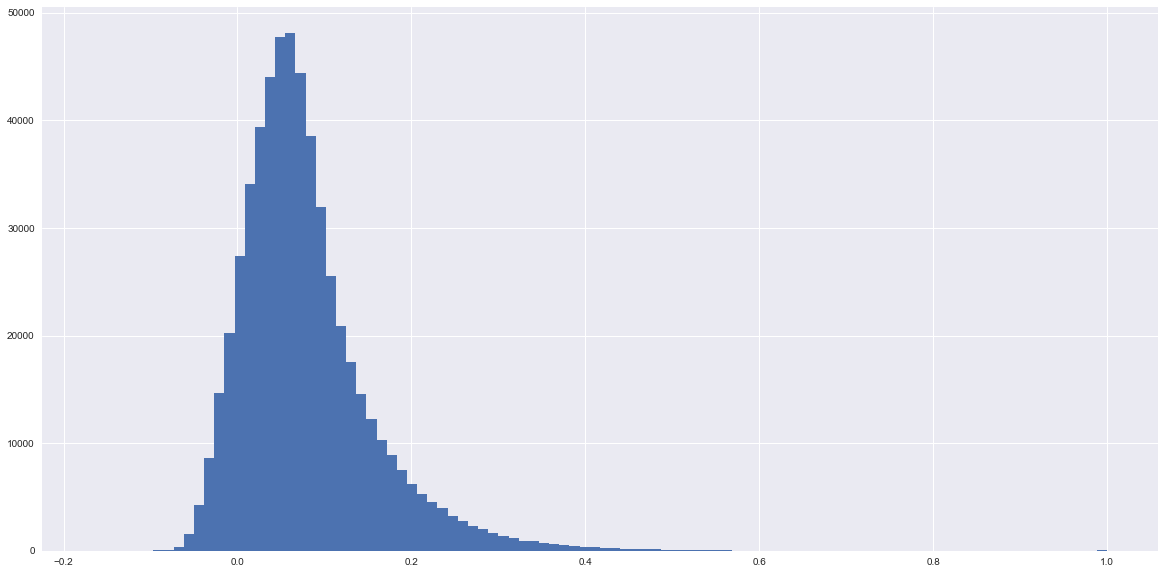

In [8]:
plt.figure(figsize=(20, 10))
comp_img.cor.hist(bins=100)

correlation coefficient distribution (values > threshold)

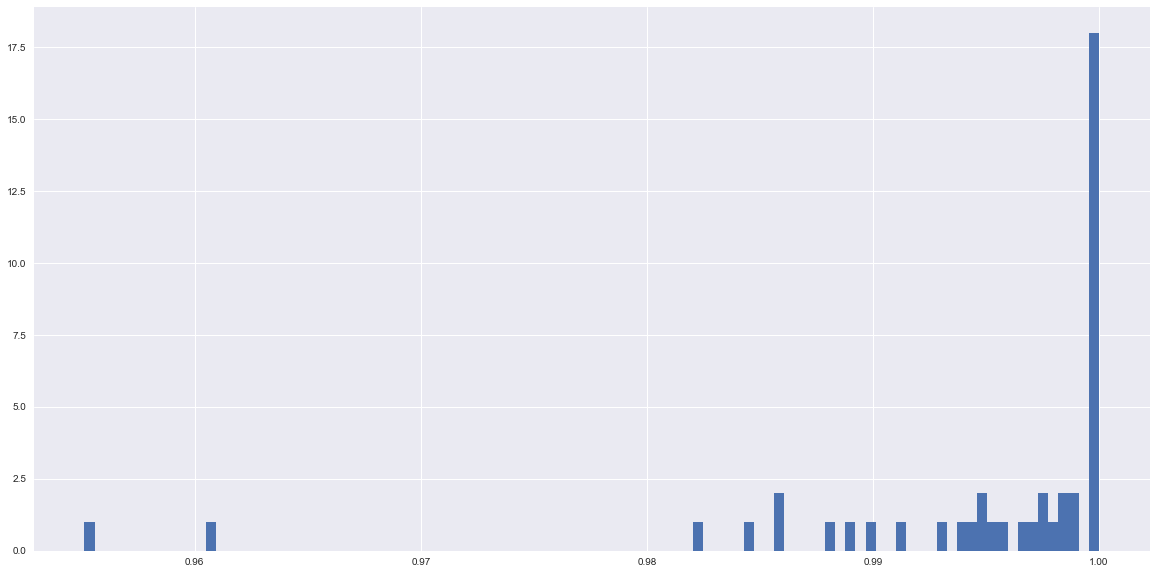

In [9]:
threshold = 0.95

plt.figure(figsize=(20, 10))
comp_img.query('cor > {}'.format(threshold)).cor.hist(bins=100)

In [10]:
print('Number of good matching', comp_img.query('cor > {}'.format(threshold)).shape[0])

Number of good matching 44


show matched configurations 

ind (first configuration_id, second configuration_id) value of correlation
0 (1237746, 6862) 1.0
1 (1227423, 469224) 1.0
2 (1238268, 595698) 1.0
3 (470542, 601971) 1.0
4 (369150, 600024) 1.0
5 (152377, 4702) 1.0
6 (469445, 470575) 1.0
7 (1228900, 1237960) 1.0
8 (4421, 602208) 1.0
9 (463490, 473064) 1.0


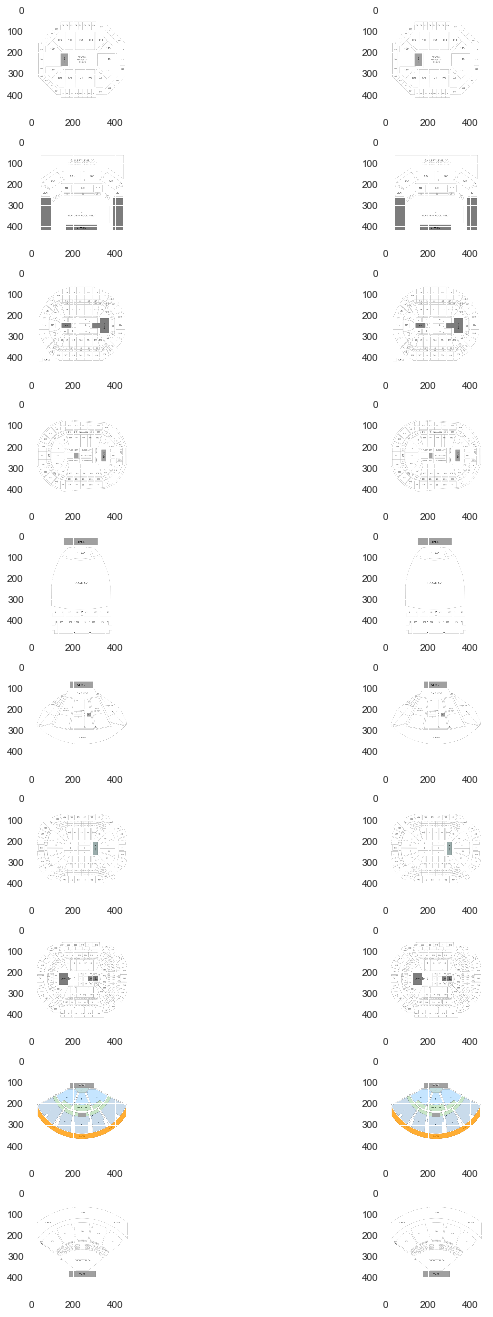

In [21]:
query_res = comp_img.query('cor > {}'.format(threshold))
query_res = query_res.sort_values(by='cor', ascending=False)
query_res = query_res.reset_index(drop=True)

show_n = 10

print('ind (first configuration_id, second configuration_id) value of correlation')
plt.figure(figsize=(10, 20))
for i, row in query_res.iterrows():
    
    if i >= show_n:
        break
    
    conf_id_0 = int(row.conf_id_f)
    conf_id_1 = int(row.conf_id_s)

    img_0 = io.imread(os.path.join(png_dir_org, str(conf_id_0) + '.png'))
    img_1 = io.imread(os.path.join(png_dir_org, str(conf_id_1) + '.png'))
    
    print(i, (conf_id_0, conf_id_1),  row.cor)

    plt.subplot(show_n + 1, 2, i * 2 + 1)
    io.imshow(img_0, )
    plt.subplot(show_n + 1, 2, i * 2 + 2)
    io.imshow(img_1)

# stubhub_ven_conf_map
calculate correlation between maps the same venue_id

In [12]:
stubhub_ven_conf_map = pd.read_csv('stubhub_ven_conf_map.csv', index_col=0)
stubhub_ven_conf_map.head()

,venue_id,configurationId,svg_map
0,88,69,"<svg height=""180"" preserveAspectRatio=""xMinYMi..."
1,88,58,"<svg height=""232"" preserveAspectRatio=""xMinYMi..."
2,84,88,"<svg height=""232"" preserveAspectRatio=""xMinYMi..."
3,102,101,"<svg height=""232"" preserveAspectRatio=""xMinYMi..."
4,90,66,"<svg height=""180"" preserveAspectRatio=""xMinYMi..."


Calculate correlation_coefficient

In [13]:
conf_id_f_arr = []
conf_id_s_arr = []
nrmse_arr = []
venue_id_arr = []

pbar = tqdm(total=stubhub_ven_conf_map.venue_id.unique().shape[0])
for venue_id in stubhub_ven_conf_map.venue_id.unique():
    sub_df = stubhub_ven_conf_map[stubhub_ven_conf_map['venue_id']==venue_id]
    for i, conf_id_f in enumerate(sub_df.configurationId):
        img_main = img_dic[int(conf_id_f)]
        
        for j, conf_id_s in enumerate(sub_df.configurationId):
            
            if conf_id_f == conf_id_s:
                continue
                
            if j <= i:
                continue
                
            img_cur = img_dic[int(conf_id_s)]
            
            cor = correlation_coefficient(img_main, img_cur)
            
            venue_id_arr.append(venue_id)
            conf_id_f_arr.append(conf_id_f)
            conf_id_s_arr.append(conf_id_s)
            nrmse_arr.append(cor)
            
    pbar.update(1)


 93%|█████████▎| 442/476 [00:05<00:00, 140.38it/s]

In [14]:
data = {'venue_id':venue_id_arr, 'conf_id_f': conf_id_f_arr, 'conf_id_s': conf_id_s_arr, 'cor':nrmse_arr}
stubhub_ven_conf_map_cor = pd.DataFrame(data)

stubhub_ven_conf_map_cor.to_csv('stubhub_ven_conf_map_cor.csv')
stubhub_ven_conf_map_cor.head()

,conf_id_f,conf_id_s,cor,venue_id
0,69,58,0.385080,88
1,69,1235777,0.748726,88
2,69,1236394,0.149144,88
3,58,1235777,0.421525,88
4,58,1236394,0.086159,88


## Statistic

In [15]:
threshold = 0.95

how many configuration for each venue_id

In [16]:
# venue_id = stubhub_ven_conf_map_cor.venue_id.unique()[0]

venue_id_match = {}
for venue_id in stubhub_ven_conf_map_cor.venue_id.unique():
    n_match = stubhub_ven_conf_map_cor.query('cor >= {} & venue_id == {}'.format(threshold, venue_id)).shape[0]
    
    if n_match != 0:
        venue_id_match[venue_id] = n_match

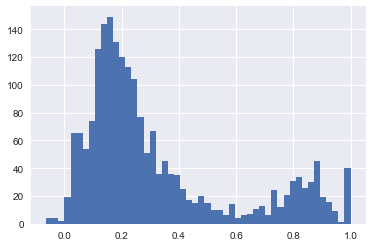

In [17]:
stubhub_ven_conf_map_cor.cor.hist(bins=50)

How many matched configuration_ids for one venue_id

Number of matching 42
Distribution of matching numbers for one venue_id Counter({1: 34, 3: 2, 2: 1})


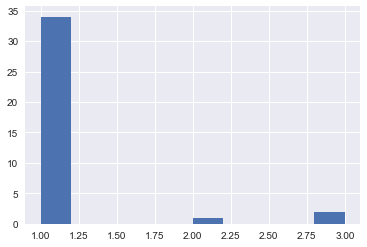

In [18]:
from collections import Counter

print('Number of matching', sum(venue_id_match.values()))

C = Counter(list(venue_id_match.values()))
print('Distribution of matching numbers for one venue_id', C)
plt.hist(list(venue_id_match.values()));

plot some examples for current venue_id

0 (2054, 104377) 0.98576272521
1 (2054, 269887) 1.0


100%|██████████| 1063/1063 [22:54<00:00,  1.29s/it]

2 (104377, 269887) 0.98576272521


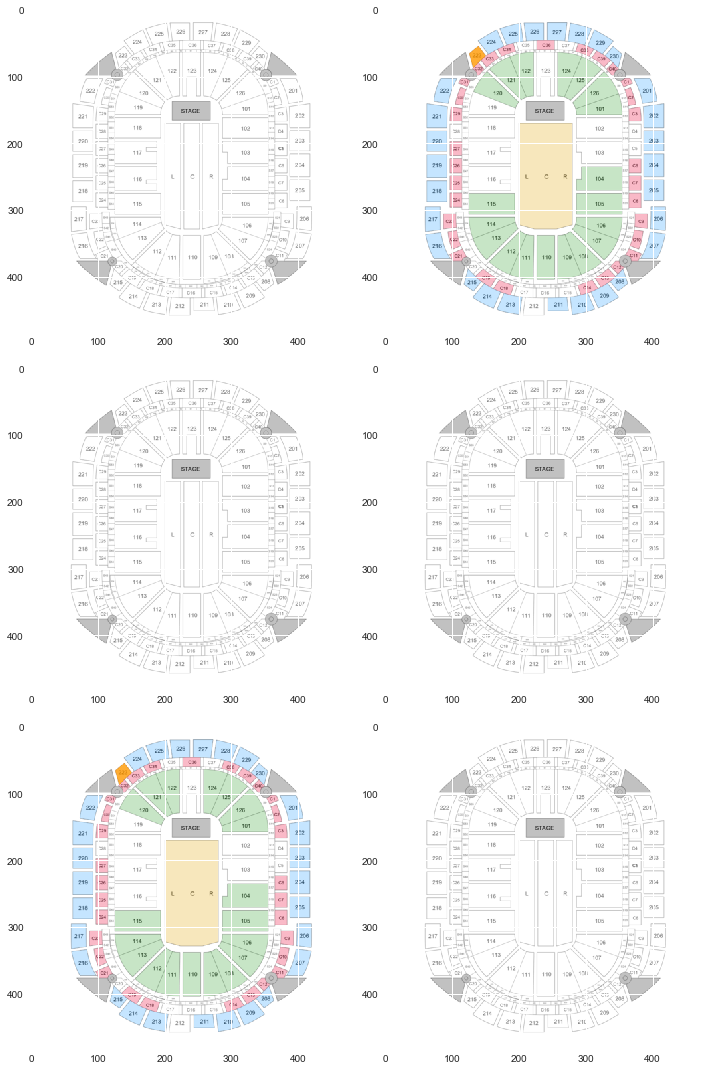

In [19]:
venue_id = 1822


query_res = stubhub_ven_conf_map_cor.query('venue_id == {} & cor > {}'.format(venue_id, threshold))
query_res = query_res.reset_index(drop=True)

plt.figure(figsize=(10, 20))
for i, row in query_res.iterrows():
    
    
    conf_id_0 = int(row.conf_id_f)
    conf_id_1 = int(row.conf_id_s)

    img_0 = io.imread(os.path.join(png_dir_org, str(conf_id_0) + '.png'))
#     img_0 = color.rgb2gray(img_0)
    img_1 = io.imread(os.path.join(png_dir_org, str(conf_id_1) + '.png'))
#     img_1 = color.rgb2gray(img_1)
    
    print(i, (conf_id_0, conf_id_1),  row.cor)

    plt.subplot(query_res.shape[0] + 1, 2, i * 2 + 1)
    io.imshow(img_0, )
    plt.subplot(query_res.shape[0] + 1, 2, i * 2 + 2)
    io.imshow(img_1)
